In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import sys
sys.path.append('../../../py/')

import h5py
from cosmoSim import cosmoSim
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

In [2]:
FONT_SIZE = 14

matplotlib.rc('xtick', labelsize=FONT_SIZE)
matplotlib.rc('ytick', labelsize=FONT_SIZE)
matplotlib.rcParams['font.size']=FONT_SIZE

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rc('text', usetex=True)

ALPHA=0.8

UNIT_HEIGHT = 5

FIG_HEIGHT = 2* UNIT_HEIGHT
FIG_WIDTH = 3 * UNIT_HEIGHT

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

snap_ranges = [
    [5, 4, 3], 
    [2, 1, 0]
]

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'
zz_dm_color = 'tab:cyan'
m2m2_dm_color = 'tab:olive'
cdm_dm_color = 'tab:pink'

In [3]:
outpath = '../../../plots/plots_L3N256/grid/'
base_path="../../../data_prods/"
data_dir = '/home/ryan/Data'
try:
    os.mkdir(outpath)
except:
    print(f'{outpath} already exists!')


# CDM_runs = ['run_CDM_L3N256_HY']

# CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

# tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

# tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

#tcDM_runs2 = ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

#tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]


CDM_runs = [ f'run_CDM_L3N256_HY_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_HY']

#CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

#tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

tcDM_runs2 = [ f'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

#tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]

../../../plots/plots_L3N256/grid/ already exists!


In [4]:
def get_samples(domain, interpf_list):
    return [ interpf(domain) for interpf in interpf_list ]

def get_dk_averages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)
    lims, pk_interp, dk_interp, k_ny =  run.interp_combined_power_spectra(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        lims, pk_interp, interp, k_ny =  run.interp_combined_power_spectra(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_SFR_avgerages(run_list, redshift):
    run = cosmoSim(run_list[0], base_path=base_path)

    idx = run.redshift_to_index(redshift)

    fof = os.path.join(data_dir, run_list[0], f'fof_subhalo_tab_{idx:03}.hdf5')
    with h5py.File(fof, 'r') as f:
        hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
        nonzero = hmass[ hmass != 0 ]
        SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
    inf = np.amin(nonzero)
    sup = np.amax(nonzero)
    
    interps = []
    
    for run_n in run_list:
        
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_list[0], f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]

        lims = [np.amin(nonzero), np.amax(nonzero)]
        
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]
        
        interps.append(interp1d(nonzero, SFR))
    
    return (inf, sup), interps  

def calculate_averages(domain, interps):
    samps = get_samples(domain, interps)
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def calculate_ratios(domain, interps_numerator, interps_denominator):
    samps_numerator = get_samples(domain, interps_numerator)
    samps_denominator = get_samples(domain, interps_denominator)

    samps = [ num / den for num, den in zip(samps_numerator, samps_denominator) ]
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety


def get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=False):

    if function == 'dk':
        get_avg_func = get_dk_averages
    elif function == 'SFR':
        get_avg_func = get_SFR_avgerages

    clims, CDM_interps = get_avg_func(CDM_runs, redshift)
    tlims, tcDM_interps = get_avg_func(tcDM_runs, redshift)

    inf = clims[0] if clims[0] > tlims[0] else tlims[0]
    sup = clims[1] if clims[1] < tlims[1] else tlims[1]

    domain = np.geomspace(inf, sup, num=10000)

    if ratios:
        ratio_samps, ratios_ten, ratios_ninety = calculate_ratios(domain, tcDM_interps, CDM_interps)
        return domain, (ratio_samps, ratios_ten, ratios_ninety)
    else:
        CDM_avg, CDM_ten, CDM_ninety = calculate_averages(domain, CDM_interps)
        tcDM_avg, tcDM_ten, tcDM_ninety = calculate_averages(domain, tcDM_interps)

        return domain, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety)

In [5]:
def read_SFR_mass(f):
    hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
    nonzero = hmass[ hmass != 0 ]
    SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]

    return nonzero, SFR

def read_smass_mass(f):
    
    hmass = f['Subhalo/SubhaloMass'][()] * 10**10
    
    smass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
    nonzero_smass = smass[ smass != 0 ]
    nonzero_hmass = hmass[ smass != 0 ] 
    
    return nonzero_hmass, nonzero_smass

def get_SFR_mass_stats(run_list, redshift, nbins=100):
    hmasses = np.array([])
    SFRs = np.array([])
    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass, SFR = read_SFR_mass(f)
        hmasses = np.append(hmasses, hmass)
        SFRs = np.append(SFRs, SFR)
    
    m_bins = np.geomspace(np.amin(hmasses), np.amax(hmasses), num=nbins)

    medians = binned_statistic(hmasses, SFRs, statistic='median', bins=m_bins)
    tenth = binned_statistic(hmasses, SFRs, statistic=lambda x: np.percentile(x, q=10), bins=m_bins)
    ninetieth = binned_statistic(hmasses, SFRs, statistic=lambda x: np.percentile(x, q=90), bins=m_bins)
    
    return m_bins[:-1], medians.statistic, tenth.statistic, ninetieth.statistic

def get_halo_stellar_mass_stats(run_list, redshift, nbins=100):
    hmasses = np.array([])
    smasses = np.array([])
    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            hmass, smass = read_smass_mass(f)
        hmasses = np.append(hmasses, hmass)
        smasses = np.append(smasses, smass)
    
    m_bins = np.geomspace(np.amin(hmasses), np.amax(hmasses), num=nbins)

    medians = binned_statistic(hmasses, smasses, statistic='median', bins=m_bins)
    tenth = binned_statistic(hmasses, smasses, statistic=lambda x: np.percentile(x, q=10), bins=m_bins)
    ninetieth = binned_statistic(hmasses, smasses, statistic=lambda x: np.percentile(x, q=90), bins=m_bins)
    
    return m_bins[:-1], medians.statistic, tenth.statistic, ninetieth.statistic

def get_quenched_fraction(run_list, redshift, eps=1e-11):
    
    total = 0
    quenched = 0
    
    for run_n in run_list:
        
        run = cosmoSim(run_n, base_path=base_path)

        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        
        with h5py.File(fof, 'r') as f:
            hmass = f['Subhalo/SubhaloMassType'][()][:,4] * 10**10
            nonzero = hmass[ hmass != 0 ]
            SFR = f['Subhalo/SubhaloSFR'][()][ hmass != 0 ]
        
        sSFR = SFR / nonzero

        total += len(nonzero)
        quenched += (sSFR < eps).sum()

    return quenched / total

In [6]:
def flatten(xss):
    return [x for xs in xss for x in xs]

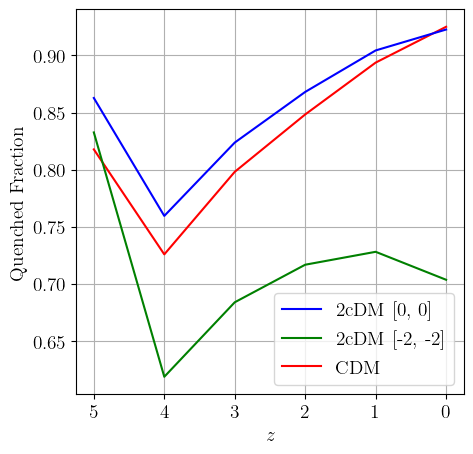

In [15]:
fig, ax = plt.subplots(1,1, figsize=[5, 5])

cdm_qfs = [ get_quenched_fraction(CDM_runs, redshift) for redshift in flatten(snap_ranges) ]
tcdm_qfs1 = [ get_quenched_fraction(tcDM_runs1, redshift) for redshift in flatten(snap_ranges) ]
tcdm_qfs2 = [ get_quenched_fraction(tcDM_runs2, redshift) for redshift in flatten(snap_ranges) ]

ax.plot(flatten(snap_ranges), cdm_qfs, color=cdm_color)
ax.plot(flatten(snap_ranges), tcdm_qfs1, color=zz_color)
ax.plot(flatten(snap_ranges), tcdm_qfs2, color=m2m2_color)

ax.grid(True, which="both", ls="-")
ax.set_aspect( 'auto', adjustable='box' )

ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
ax.plot([],[], label='CDM', color=cdm_color)

ax.set_xlabel('$z$')
ax.set_ylabel('Quenched Fraction')

ax.invert_xaxis()

ax.legend()
fname = outpath + f'quenched_fraction.pdf'
plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()

<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3156083/1922110785.py:38: SyntaxWarning: invalid escape sequence '\o'
  ar.set_ylabel("SFR [$M_{\odot}$ yr$^{-1}$]")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {

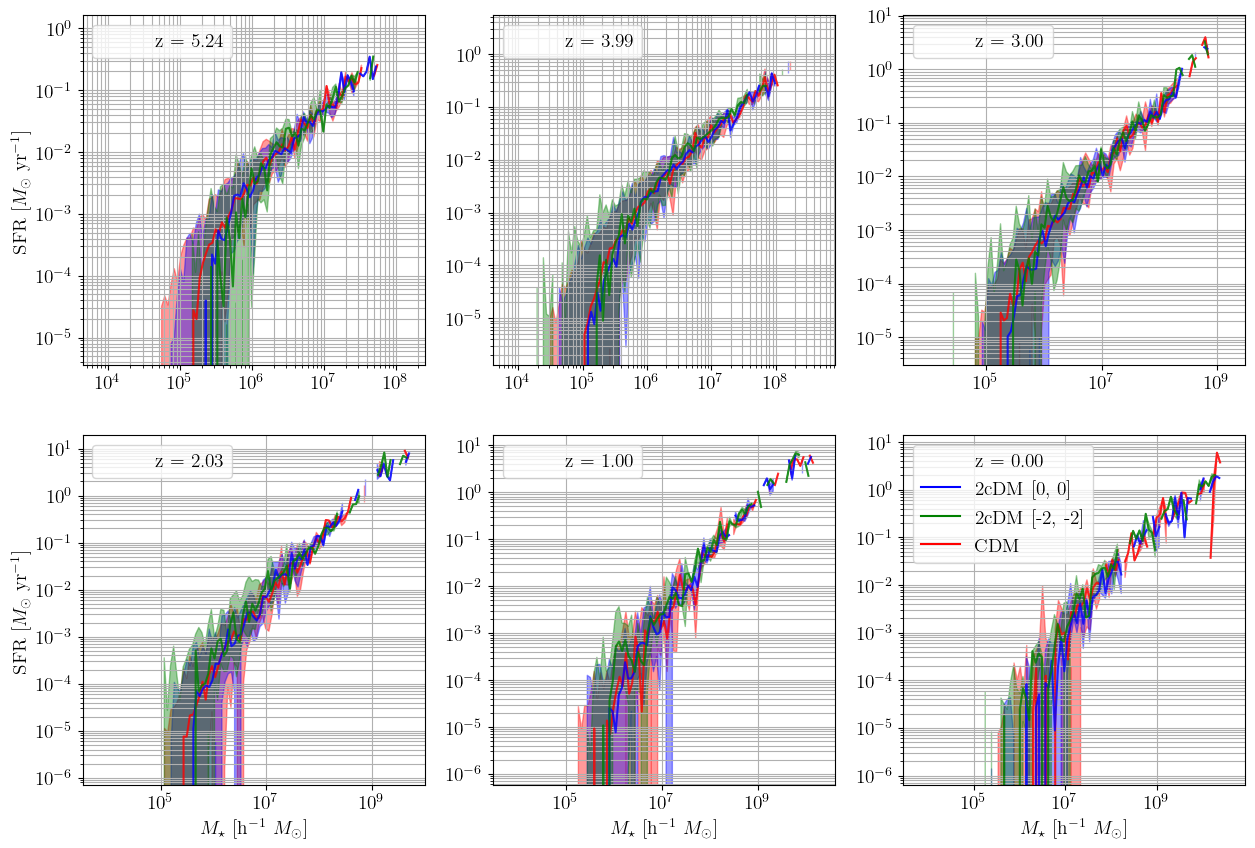

In [35]:
fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)

for ar, snap_range in zip(ax, snap_ranges):
    for a, redshift in zip(ar, snap_range):

        cdm_m, cdm_med, cdm_10, cdm_90 = get_SFR_mass_stats(CDM_runs, redshift)

        tcdm_m, tcdm_med, tcdm_10, tcdm_90 = get_SFR_mass_stats(tcDM_runs1, redshift)

        twcdm_m, twcdm_med, twcdm_10, twcdm_90 = get_SFR_mass_stats(tcDM_runs2, redshift)

        a.plot(cdm_m, cdm_med, alpha=ALPHA, color=cdm_color)
        a.fill_between(cdm_m, cdm_10, cdm_90, alpha=0.5*ALPHA, color=cdm_color)

        a.plot(tcdm_m, tcdm_med, alpha=ALPHA, color=zz_color)
        a.fill_between(tcdm_m, tcdm_10, tcdm_90, alpha=0.5*ALPHA, color=zz_color)

        a.plot(twcdm_m, twcdm_med, alpha=ALPHA, color=m2m2_color)
        a.fill_between(twcdm_m, twcdm_10, twcdm_90, alpha=0.5*ALPHA, color=m2m2_color)

        r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)


        a.set_yscale("log")
        a.set_xscale("log")
        # a.set_xlim(10**-2, 10**1)
        # a.set_ylim(10**-8, 10**1)
        a.grid(True, which="both", ls="-")
        a.set_aspect( 'auto', adjustable='box' )
        a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
        a.legend()


for ar in ax[1, :]:
    ar.set_xlabel('$M_{\\star}$ [h$^{-1}$ $M_{\\odot}$]')

for ar in ax[:, 0]: 
    ar.set_ylabel("SFR [$M_{\odot}$ yr$^{-1}$]")

a = ax[-1,-1]
a.plot([],[], label='2cDM [0, 0]', color=zz_color)
a.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
a.plot([],[], label='CDM', color=cdm_color)

a.legend()
fname = outpath + f'grid_SFR_mass.pdf'
plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()

/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_0!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N256_HY_dir_1!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]} in run {self.run_name}!")
/home/ryan/projects/Medvedev/dm_sims/jupyter/global/paperI/../../../py/cosmoSim.py:118: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.236226422509304 in run run_CDM_L3N

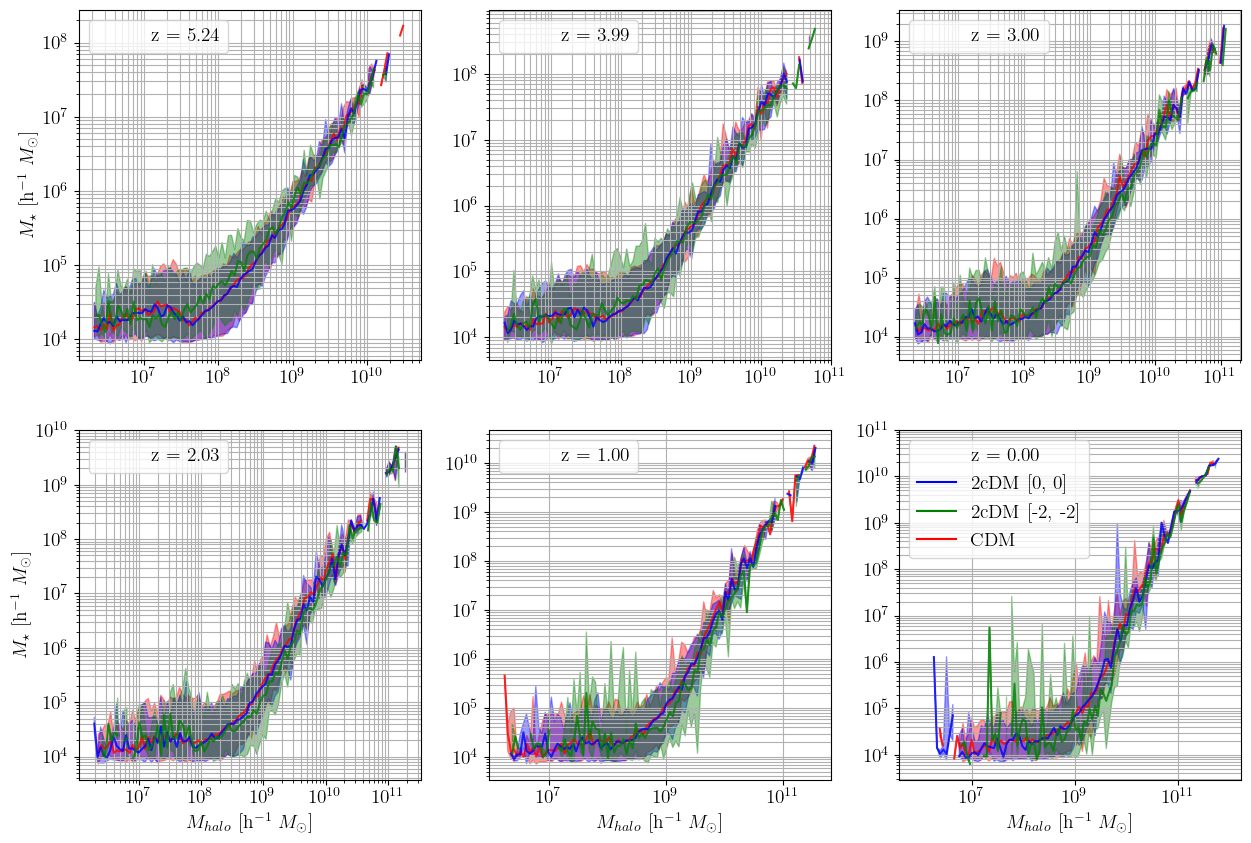

In [36]:
fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)

for ar, snap_range in zip(ax, snap_ranges):
    for a, redshift in zip(ar, snap_range):

        cdm_m, cdm_med, cdm_10, cdm_90 = get_halo_stellar_mass_stats(CDM_runs, redshift)

        tcdm_m, tcdm_med, tcdm_10, tcdm_90 = get_halo_stellar_mass_stats(tcDM_runs1, redshift)

        twcdm_m, twcdm_med, twcdm_10, twcdm_90 = get_halo_stellar_mass_stats(tcDM_runs2, redshift)

        a.plot(cdm_m, cdm_med, alpha=ALPHA, color=cdm_color)
        a.fill_between(cdm_m, cdm_10, cdm_90, alpha=0.5*ALPHA, color=cdm_color)

        a.plot(tcdm_m, tcdm_med, alpha=ALPHA, color=zz_color)
        a.fill_between(tcdm_m, tcdm_10, tcdm_90, alpha=0.5*ALPHA, color=zz_color)

        a.plot(twcdm_m, twcdm_med, alpha=ALPHA, color=m2m2_color)
        a.fill_between(twcdm_m, twcdm_10, twcdm_90, alpha=0.5*ALPHA, color=m2m2_color)

        r_nearest = cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(redshift)


        a.set_yscale("log")
        a.set_xscale("log")
        # a.set_xlim(10**-2, 10**1)
        # a.set_ylim(10**-8, 10**1)
        a.grid(True, which="both", ls="-")
        a.set_aspect( 'auto', adjustable='box' )
        a.plot([],[], label=f'z = {r_nearest:.2f}', alpha=0)
        a.legend()

for ar in ax[1, :]:
    ar.set_xlabel('$M_{halo}$ [h$^{-1}$ $M_{\\odot}$]')

for ar in ax[:, 0]: 
    ar.set_ylabel('$M_{\\star}$ [h$^{-1}$ $M_{\\odot}$]')

a = ax[-1,-1]
a.plot([],[], label='2cDM [0, 0]', color=zz_color)
a.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
a.plot([],[], label='CDM', color=cdm_color)

a.legend()
fname = outpath + f'grid_halomass_stellarmass.pdf'
plt.savefig(fname, dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
def get_group_stats_inner(run_list, redshift):
    counts = []
    for run_n in run_list:
        run = cosmoSim(run_n, base_path=base_path)
        idx = run.redshift_to_index(redshift)

        fof = os.path.join(data_dir, run_n, f'fof_subhalo_tab_{idx:03}.hdf5')
        with h5py.File(fof, 'r') as f:
            counts.append(f['Group/GroupNsubs'][0])
    
    med = np.median(counts)
    ten = np.percentile(counts, 10)
    nin = np.percentile(counts, 90)

    return med, ten, nin 

def get_group_stats(run_list, redshifts):
    meds = []
    tens = []
    nins = []

    for redshift in redshifts:
        med, ten, nin = get_group_stats_inner(run_list, redshift)
        meds.append(med)
        tens.append(ten)
        nins.append(nin)
    return meds, tens, nins

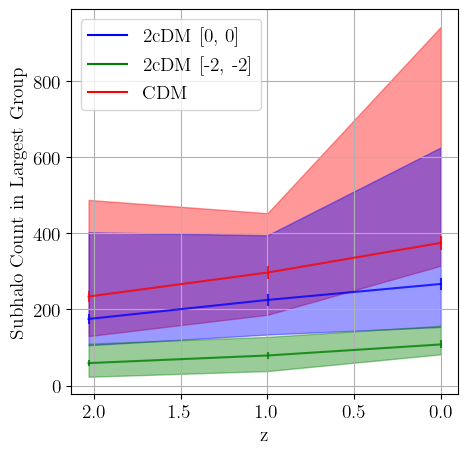

In [26]:
fig, ax = plt.subplots(1,1, figsize=[5, 5])

CDM_meds, CDM_tens, CDM_nins = get_group_stats(CDM_runs, snap_range)
tcDM_meds1, tcDM_tens1, tcDM_nins1 = get_group_stats(tcDM_runs1, snap_range)
tcDM_meds2, tcDM_tens2, tcDM_nins2 = get_group_stats(tcDM_runs2, snap_range)

redshifts = [ cosmoSim(CDM_runs[0], base_path=base_path).get_nearest_redshift(s) for s in snap_range ]

ax.errorbar(redshifts, CDM_meds, yerr=np.sqrt(CDM_meds), alpha=ALPHA, color=cdm_color)
# ax.errorbar(redshifts, np.sqrt(CDM_meds), alpha=ALPHA, color=cdm_color)
ax.fill_between(redshifts, CDM_tens, CDM_nins, alpha=0.5*ALPHA, color=cdm_color)

ax.errorbar(redshifts, tcDM_meds1, yerr=np.sqrt(tcDM_meds1), alpha=ALPHA, color=zz_color)
# ax.errorbar(redshifts, np.sqrt(tcDM_meds1), alpha=ALPHA, color=zz_color)
ax.fill_between(redshifts, tcDM_tens1, tcDM_nins1, alpha=0.5*ALPHA, color=zz_color)

ax.errorbar(redshifts, tcDM_meds2, yerr=np.sqrt(tcDM_meds2), alpha=ALPHA, color=m2m2_color)
# ax.errorbar(redshifts, np.sqrt(tcDM_meds2), alpha=ALPHA, color=m2m2_color)
ax.fill_between(redshifts, tcDM_tens2, tcDM_nins2, alpha=0.5*ALPHA, color=m2m2_color)

ax.grid(True, which="both", ls="-")

ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)
ax.plot([],[], label='CDM', color=cdm_color)

ax.xaxis.set_inverted(True)

ax.set_xlabel('z')
ax.set_ylabel('Subhalo Count in Largest Group')

plt.legend()
plt.savefig(outpath + 'large_group_subhalo_count.pdf', dpi=DPI, bbox_inches='tight')
plt.show()